## Imports

In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import kaolin as kal
import cv2
from collections import defaultdict
import trimesh
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

object = 'bookshelf' 
obj_path = 'data/demo/' + object + '.obj'

Torch will run on: cuda:0


## Read Mesh

In [2]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()
colors =  mesh.vertex_normals.cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  5786
Number of faces:  8624


## Sample Points on mesh surface

In [3]:
# Visualize mesh
trimeshMesh = trimesh.Trimesh(vertices, faces)
# N = int(vertices.shape[0] * 2)
N = int(vertices.shape[0] / 2)
point_cloud, pt_to_face = trimesh.sample.sample_surface_even(trimeshMesh, N)
torchPC = torch.tensor(point_cloud, device=torch.device('cuda:0'), dtype=torch.float32)
face_to_all_pts = defaultdict(list)
for pt in range(len(point_cloud)):
    face_to_all_pts[pt_to_face[pt]].append(pt)
p = mp.plot(vertices, faces, colors, return_plot=True, shading={"wireframe": 0.1})
p.add_points(point_cloud, shading={"point_size": 0.1, "point_color": "green"})
plt.show()

only got 1857/2893 samples!


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

c:\ProgramData\miniforge3\envs\test_proj\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


## Define rendering functions

In [4]:
def get_camera_from_view2(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = - pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)
    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

def get_camera_properties(elev, azim, r):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    eye = torch.tensor([x, y, z], device=device)
    look_at = - eye
    look_at /= torch.norm(look_at)
    up = torch.tensor([0.0, 1.0, 0.0], device=device)
    right = torch.cross(look_at, up)
    right /= torch.norm(right)
    up = torch.cross(right, look_at)
    up /= torch.norm(up)
    return eye, look_at, up, right

def render_view(elev, azim, r):
    background = torch.tensor([255.0, 255.0, 255.0]).to(device)
    # face_attributes = kal.ops.mesh.index_vertices_by_faces(
    #     torch.ones(1, len(mesh.vertices), 3).to(device)
    #     * torch.tensor([0.5, 0.5, 0.5]).unsqueeze(0).unsqueeze(0).to(device),
    #     faces_tensor,
    # )
    face_attributes = kal.ops.mesh.index_vertices_by_faces(
            mesh.vertex_normals.unsqueeze(0).to(device),
            faces_tensor
    ) 
    face_attributes = [
        face_attributes,  # Colors
        torch.ones((1, faces.shape[0], 3, 1), device=device),  # hard seg. mask
    ]
    
    camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
    camera_transform = get_camera_from_view2(elev, azim, r=r).to(device)
    (
        face_vertices_camera,
        face_vertices_image,
        face_normals,
    ) = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device),
        mesh.faces.to(device),
        camera_projection,
        camera_transform=camera_transform,
    )

    # v = mesh.vertices[faces[0, 0]].to(device).unsqueeze(0)
    # v = torch.cat((v, torch.tensor([[1]], device=device)), 1)
    # print(face_vertices_camera.squeeze()[0, 0].unsqueeze(0))
    # print(torch.mm(v, camera_transform.squeeze()))
    # print(face_vertices_image[0,0,0])

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        1024,
        1024,
        face_vertices_camera[:, :, :, -1],
        face_vertices_image,
        face_attributes,
        face_normals[:, :, -1],
    )

    image_features, mask = image_features
    image = torch.clamp(image_features, 0.0, 1.0)
    lights=torch.tensor([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0).to(device)
    image_normals = face_normals[:, face_idx].squeeze(0)
    image_lighting = kal.render.mesh.spherical_harmonic_lighting(
        image_normals, lights
        ).unsqueeze(0)
    image = image * image_lighting.repeat(1, 3, 1, 1).permute(
        0, 2, 3, 1
        ).to(device)
    image = torch.clamp(image, 0.0, 1.0)
    background_mask = torch.zeros(image.shape).to(device)
    mask = mask.squeeze(-1)
    background_idx = torch.where(mask == 0)
    assert torch.all(
        image[background_idx] == torch.zeros(3).to(device)
    )  # Remvoe it may be taking a lot of time
    background_mask[
        background_idx
    ] = background  # .repeat(background_idx[0].shape)
    image = torch.clamp(image + background_mask, 0.0, 1.0)
    image = image.squeeze().cpu().numpy()
    image *= 255.0
    image = image.astype(np.uint8)
    return image, face_idx

from SAM import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="./SAM/MODEL/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Build SPC from Point Cloud

In [79]:
# Our SPC will contain a hierarchy of multiple levels
level = 7
torch.manual_seed(0)
# colors = torch.rand(point_cloud.shape[0], 3, device=device)
# colors = torch.tensor(point_cloud, device=device)
# colors = torch.tensor(point_cloud[:,:1]).to(device)
colors = torch.arange(0, point_cloud.shape[0]).unsqueeze(1).to(device)
# mp.plot(point_cloud, c = colors.cpu().numpy(), shading={'point_size':0.2})
# plt.show()
spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(
    pointcloud=torchPC, level=level, features=colors)
octree, features = spc.octrees, spc.features
point_hierarchy, pyramid, prefix = spc.point_hierarchies, spc.pyramids[0], spc.exsum

## Define functions for ray generation

In [72]:
def _normalized_grid(width, height, device='cuda'):
    """Returns grid[x,y] -> coordinates for a normalized window.
    
    Args:
        width, height (int): grid resolution
    """

    # These are normalized coordinates
    # i.e. equivalent to 2.0 * (fragCoord / iResolution.xy) - 1.0
    window_x = torch.linspace(-1, 1, steps=width, device=device) * (width / height)
    window_y = torch.linspace(1,- 1, steps=height, device=device)

    coord = torch.stack(torch.meshgrid(window_x, window_y)).permute(1,2,0)
    return coord


def generate_rays(camera_from, camera_to, width, height, mode='persp', fov=90.0, device='cuda'):
    """Vectorized look-at function, returns an array of ray origins and directions
    URL: https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function
    """

    camera_origin = torch.FloatTensor(camera_from).to(device)
    camera_view = F.normalize(torch.FloatTensor(camera_to).to(device) - camera_origin, dim=0)
    camera_right = F.normalize(torch.cross(camera_view, torch.FloatTensor([0,1,0]).to(device)), dim=0)
    camera_up = F.normalize(torch.cross(camera_right, camera_view), dim=0)

    coord = _normalized_grid(width, height, device=device)
    ray_origin = camera_right * coord[...,0,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_up * coord[...,1,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_origin + camera_view
    ray_origin = ray_origin.reshape(-1, 3)
    ray_offset = camera_view.unsqueeze(0).repeat(ray_origin.shape[0], 1)
    
    if mode == 'ortho': # Orthographic camera
        ray_dir = F.normalize(ray_offset, dim=-1)
    elif mode == 'persp': # Perspective camera
        ray_dir = F.normalize(ray_origin - camera_origin, dim=-1)
        ray_origin = camera_origin.repeat(ray_dir.shape[0], 1)
    else:
        raise ValueError('Invalid camera mode!')


    return ray_origin, ray_dir

def build_ray_at(pixel, eye, up, look_at, right, fov, width, height, show=False, col='red'):    
    aspect_ratio = width / height
    u = (pixel[1] + 0.5) / width
    v = 1. - (pixel[0] + 0.5) / height
    w = 2. * np.tan(fov / 2.)
    rayDirection = look_at + ((u-0.5) * aspect_ratio * w) * right - ((0.5 - v) * w) * up
    
    rayDirection = rayDirection / torch.norm(rayDirection)
    # p.add_points(eye.unsqueeze(0).cpu().numpy(), shading={'point_size':0.25, 'point_color':'green'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*look_at).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*up).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    # p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 0.6*right).unsqueeze(0).cpu().numpy(), shading={'line_color':'black'})
    if (show):
        p.add_lines(eye.unsqueeze(0).cpu().numpy(), (eye + 3.*rayDirection).unsqueeze(0).cpu().numpy(), shading={'line_color':col})
    return eye, rayDirection

def generate_rays_bb(bbox, elev, azim, r):
    ray_o = []
    ray_d = []
    eye, look_at, up, right = get_camera_properties(elev, azim, r)
    (startX, startY) , (endX, endY) = (bbox[0], bbox[1])
    for row in range(startY, endY):
        for col in range(startX, endX):
            pixel = (row, col)
            rayOrigin, rayDirection = build_ray_at(pixel, eye, up, look_at, right, fov, width=1024, height=1024)
            ray_o.append(rayOrigin.cpu().numpy())
            ray_d.append(rayDirection.cpu().numpy())
    ray_o = torch.tensor(np.array(ray_o), device=device)
    ray_d = torch.tensor(np.array(ray_d), device=device)
    return ray_o, ray_d

## Generate Rays for full image

In [26]:
# ray_o and ray_d ~ torch.Tensor (width x height, 3)
# represent rays origin and direction vectors
# camera_from=[-.5,2.5,-2.5]
camera_from = [0.,0.5,2.]
camera_to = [0,0.5,0]
ray_o, ray_d = generate_rays(
                        camera_from=camera_from,
                        camera_to=camera_to,
                        width=1024,
                        height=1024,
                        mode='persp',
                        fov=60,
                        device='cuda')
np.random.seed(42)
p = mp.plot(point_cloud, shading={'point_size':0.2, 'point_color':'black'}, return_plot=True)
p.add_points(ray_o[0].view(1,3).cpu().numpy(), shading={'point_size':0.2, 'point_color':'green'})
for i in range(10):
    p.add_lines(ray_o[0].view(1,3).cpu().numpy(), (ray_o[0] + 4.*ray_d[np.random.randint(ray_d.shape[0])]).view(1,3).cpu().numpy(), shading={'line_size':0.2, 'line_color':'blue'})
plt.show()
print(f'Total of {ray_o.shape[0]} rays generated.')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

Total of 1048576 rays generated.


## Manually define single Ray

In [32]:
ray_o = torch.tensor([[0.,0.5,2.]], device=device)
# ray_d = torch.tensor([[0,0.,-1]], device=device)
ray_d = torch.tensor([[ 0.0804, -0.2346, -0.9688]], device=device)
p = mp.plot(point_cloud, shading={'point_size':0.2, 'point_color':'black'}, return_plot=True)
p.add_lines(ray_o.cpu().numpy(), (ray_o + 2.*ray_d).cpu().numpy(), shading={'line_size':0.2, 'line_color':'blue'})
p.add_points(ray_o.cpu().numpy(), shading={'point_size':0.2, 'point_color':'green'})
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

## Generate Rays in BB

Generated 40000 rays


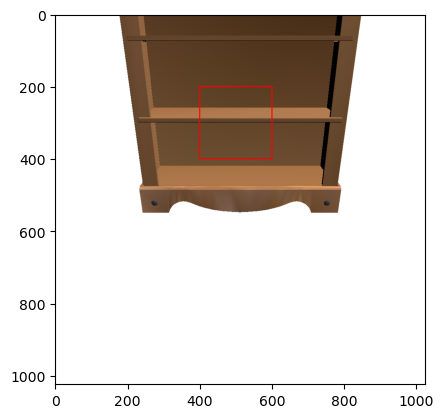

In [44]:
ray_o = []
ray_d = []
elev = torch.deg2rad(torch.tensor(25)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
r = 1.5
fov = np.pi / 3.
# startX = 310; startY = 280; endX = 350; endY = 350
startX = 400; startY = 200; endX = 600; endY = 400
image, face_idx = render_view(elev, azim, r)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
eye, look_at, up, right = get_camera_properties(elev, azim, r)
for row in range(startY, endY):
        for col in range(startX, endX):
            pixel = (row, col)
            rayOrigin, rayDirection = build_ray_at(pixel, eye, up, look_at, right, fov, width=1024, height=1024)
            ray_o.append(rayOrigin.cpu().numpy())
            ray_d.append(rayDirection.cpu().numpy())
ray_o = torch.tensor(np.array(ray_o), device=device)
ray_d = torch.tensor(np.array(ray_d), device=device)
print(f'Generated {ray_o.shape[0]} rays')
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

## Ray Trace

In [45]:
nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(
    octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
nugs_ridx = nugs_ridx[masked_nugs]
nugs_pidx = nugs_pidx[masked_nugs]
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramid[1,level]
print(f'Ray Hits: {ridx.shape[0]} out of {ray_o.shape[0]} - {np.round(ridx.shape[0] / ray_o.shape[0], 2) * 100} %')

Ray Hits: 29165 out of 40000 - 73.0 %


## Show intersection with PC

In [47]:
p = mp.plot(point_cloud, shading={'point_size':0.2, 'point_color':'black'}, return_plot=True)
p.add_points(ray_o[0].view(1, -1).cpu().numpy(), shading={'point_size':0.5, 'point_color':'green'})
for i in range(10):
    id_p = np.random.randint(ridx.shape[0])
    p.add_lines(ray_o[0].view(1, -1).cpu().numpy(), 
                (ray_o[0] + 4*ray_d[ridx[id_p]]).view(1, -1).cpu().numpy(), 
                shading={'line_color':'blue'})
    m_hit = point_cloud[features[pidx[id_p]]]
    p.add_points(m_hit.reshape(1, -1), shading={'point_size':0.5, 'point_color':'blue'})
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

## Test project back BB

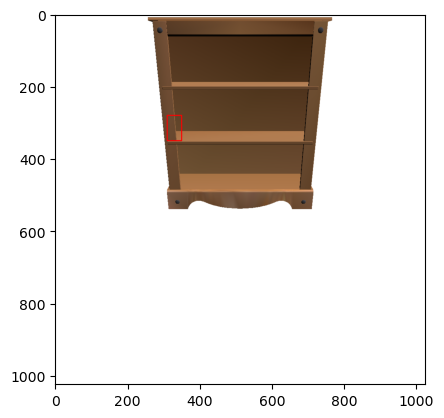

In [82]:
elev = torch.deg2rad(torch.tensor(25)).to(device)
azim = torch.deg2rad(torch.tensor(90)).to(device)
r = 2.
fov = np.pi / 3.
image, face_idx = render_view(elev, azim, r)
face_idx = face_idx.squeeze().cpu().numpy()
img_to_show = image.copy()
startX = 310; startY = 280; endX = 350; endY = 350
# startX = 400; startY = 170; endX = 430; endY = 250
bb = [(startX, startY), (endX, endY)]
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [83]:
ray_o, ray_d = generate_rays_bb(bb, elev, azim, r)
point_hierarchy, pyramid, prefix = spc.point_hierarchies, spc.pyramids[0], spc.exsum
nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(
    octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
nugs_ridx = nugs_ridx[masked_nugs]
nugs_pidx = nugs_pidx[masked_nugs]
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramid[1,level]

colors = np.zeros((point_cloud.shape[0], 3))
colors[features[pidx].squeeze().cpu().numpy()] = np.array([255,0,0])
p = mp.plot(point_cloud, c=colors, shading={'point_size':0.2}, return_plot=True)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…